Generating cross-sections...
Generating 10000 spectra...
Generated 0/10000 spectra
Generated 1000/10000 spectra
Generated 2000/10000 spectra
Generated 3000/10000 spectra
Generated 4000/10000 spectra
Generated 5000/10000 spectra
Generated 6000/10000 spectra
Generated 7000/10000 spectra
Generated 8000/10000 spectra
Generated 9000/10000 spectra
Dataset generation complete!
Preprocessing spectra...
Processed 0/10000 spectra
Processed 1000/10000 spectra
Processed 2000/10000 spectra
Processed 3000/10000 spectra
Processed 4000/10000 spectra
Processed 5000/10000 spectra
Processed 6000/10000 spectra
Processed 7000/10000 spectra
Processed 8000/10000 spectra
Processed 9000/10000 spectra
Preprocessing complete!

Sample spectra plot saved as 'sample_spectra.png'
Training CNN model...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 1.0218 - mae: 0.7407 - val_loss: 1.0205 - val_mae: 0.7419
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.0094 - mae: 0.7424 - val_loss: 1.0205

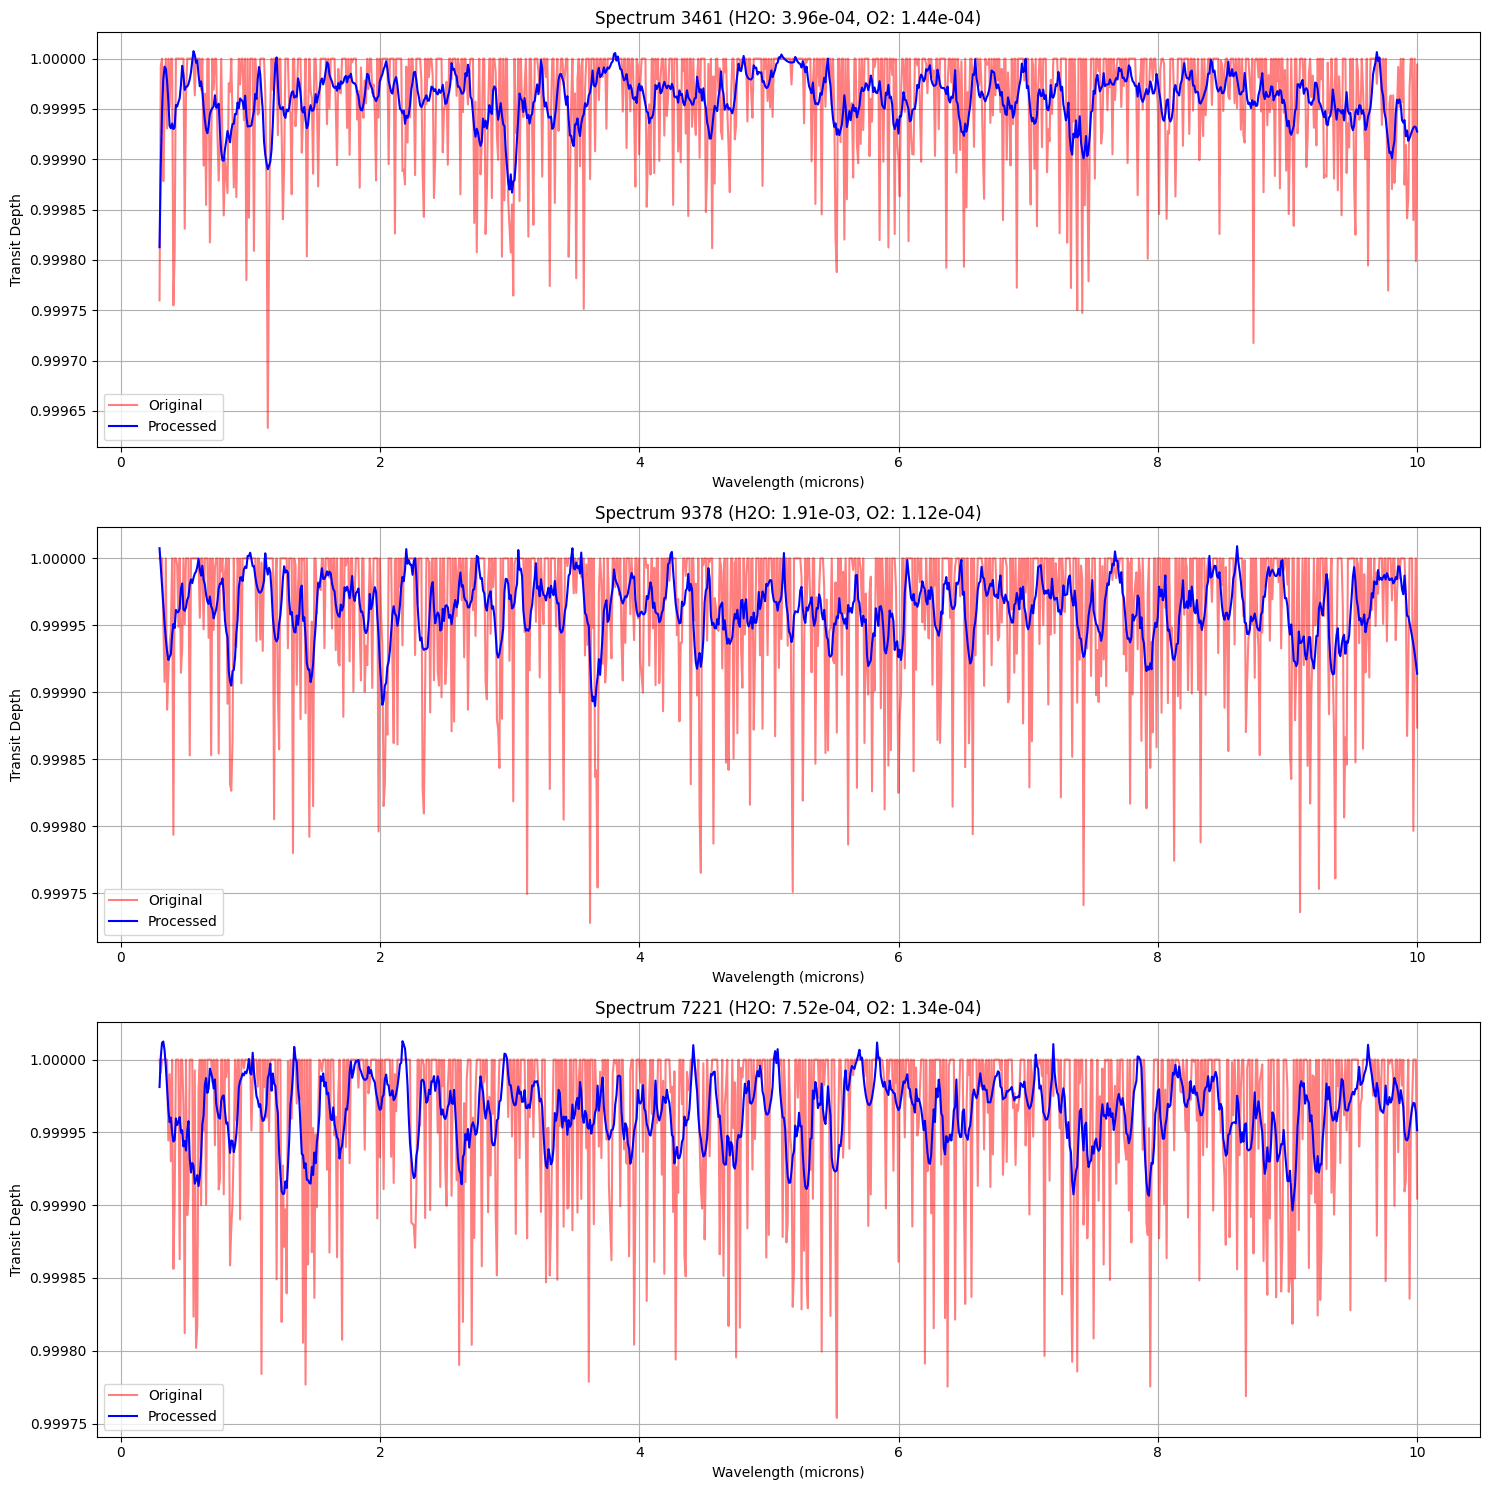

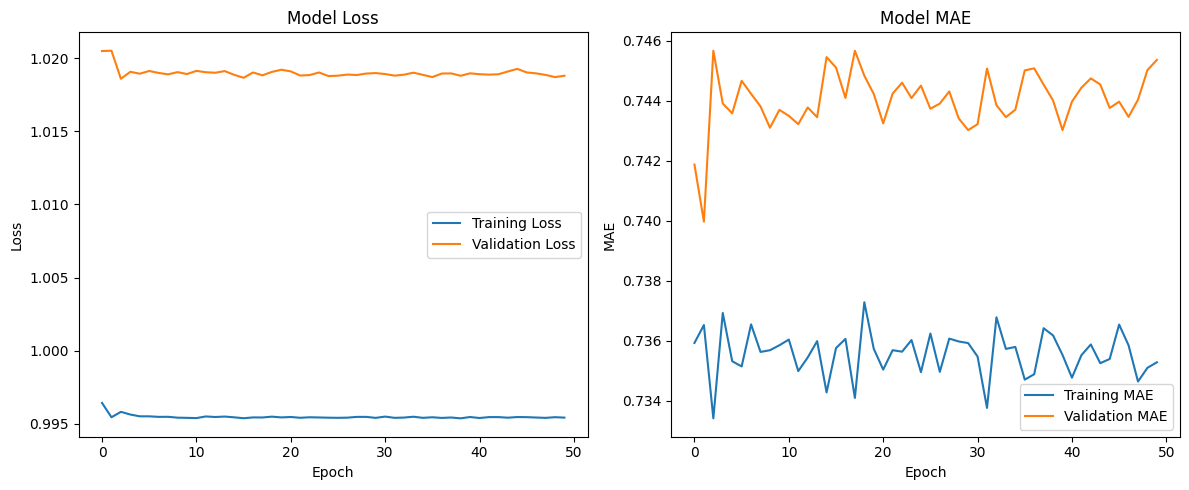

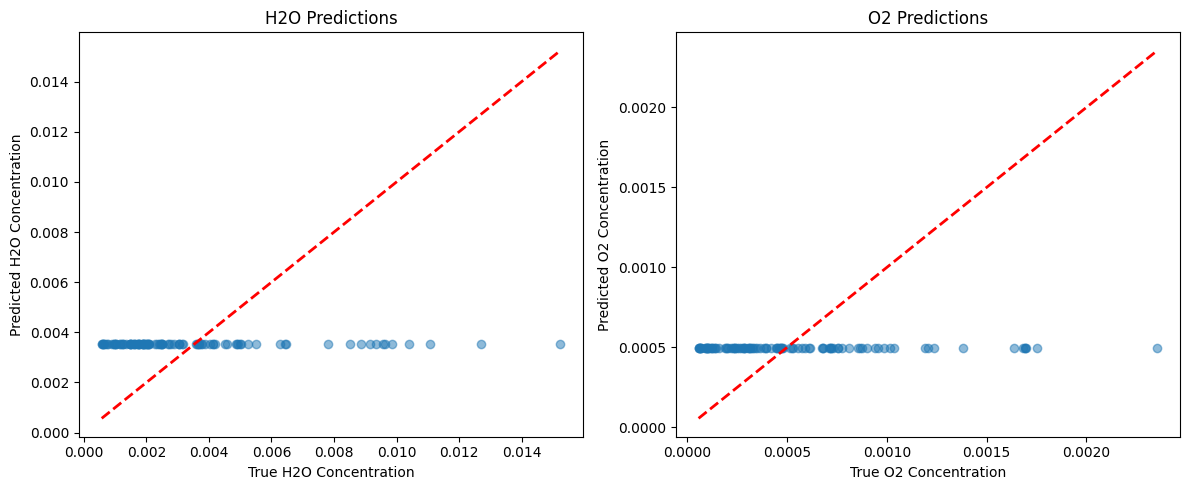

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from scipy.stats import truncnorm
from scipy.signal import savgol_filter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class TransmissionSpectraAnalyzer:
    def __init__(self, wavelength_start=0.3, wavelength_end=10.0, n_points=1000):
        """Initialize the complete pipeline."""
        self.wavelength = np.linspace(wavelength_start, wavelength_end, n_points)
        self.n_points = n_points

        # Define absorption line centers (microns) for H2O and O2
        self.h2o_lines = np.array([0.94, 1.13, 1.38, 1.88, 2.69, 3.0, 6.2])
        self.o2_lines = np.array([0.69, 0.76, 1.27])

        # Initialize scalers
        self.spectra_scaler = StandardScaler()
        self.conc_scaler = StandardScaler()

        # Initialize data containers
        self.raw_spectra = None
        self.processed_spectra = None
        self.concentrations = None

        # Initialize CNN model
        self.model = None
        self.history = None

    def generate_cross_sections(self):
        """Generate absorption cross-sections for each molecule."""
        self.h2o_xsec = np.zeros_like(self.wavelength)
        self.o2_xsec = np.zeros_like(self.wavelength)

        for line in self.h2o_lines:
            sigma = 0.01 * line
            gamma = sigma / 2.0
            self.h2o_xsec += voigt_profile(self.wavelength - line, sigma, gamma)

        for line in self.o2_lines:
            sigma = 0.005 * line
            gamma = sigma / 2.0
            self.o2_xsec += voigt_profile(self.wavelength - line, sigma, gamma)

        self.h2o_xsec = self.h2o_xsec / np.max(self.h2o_xsec)
        self.o2_xsec = self.o2_xsec / np.max(self.o2_xsec)

    def generate_random_concentrations(self, n_samples):
        """Generate random but physically plausible concentrations."""
        h2o_conc = np.exp(truncnorm.rvs(-2, 2, loc=-6, scale=1, size=n_samples))
        o2_conc = np.exp(truncnorm.rvs(-2, 2, loc=-8, scale=1, size=n_samples))
        return h2o_conc, o2_conc

    def calculate_optical_depth(self, h2o_conc, o2_conc):
        """Calculate optical depth based on concentrations and cross-sections."""
        return (h2o_conc * self.h2o_xsec + o2_conc * self.o2_xsec)

    def add_atmospheric_effects(self, tau):
        """Add effects of atmospheric scale height and planet parameters."""
        H = 100_000  # scale height in meters
        R_p = 7e7    # planet radius in meters
        r_eff = R_p + H * tau
        transit_depth = (r_eff / R_p) ** 2
        return transit_depth

    def add_noise(self, spectrum, noise_level=0.0001):
        """Add realistic instrumental and systematic noise."""
        noise = np.random.normal(0, noise_level, len(spectrum))
        return np.clip(spectrum + noise, 0, 1)

    def generate_dataset(self, n_samples=10000):
        """Generate complete dataset with spectra and concentrations."""
        print("Generating cross-sections...")
        self.generate_cross_sections()

        print(f"Generating {n_samples} spectra...")
        h2o_conc, o2_conc = self.generate_random_concentrations(n_samples)
        spectra = np.zeros((n_samples, len(self.wavelength)))

        for i in range(n_samples):
            tau = self.calculate_optical_depth(h2o_conc[i], o2_conc[i])
            spectrum = self.add_atmospheric_effects(tau)
            spectrum = self.add_noise(spectrum)
            spectra[i] = spectrum

            if i % 1000 == 0:
                print(f"Generated {i}/{n_samples} spectra")

        self.raw_spectra = spectra
        self.concentrations = np.column_stack([h2o_conc, o2_conc])

        print("Dataset generation complete!")

    def preprocess_data(self):
        """Preprocess the spectral data."""
        print("Preprocessing spectra...")
        processed = np.zeros_like(self.raw_spectra)

        for i in range(len(self.raw_spectra)):
            # Apply Savitzky-Golay filter for denoising
            spectrum = savgol_filter(self.raw_spectra[i], window_length=15, polyorder=3)
            processed[i] = spectrum

            if i % 1000 == 0:
                print(f"Processed {i}/{len(self.raw_spectra)} spectra")

        # Scale the data
        self.processed_spectra = self.spectra_scaler.fit_transform(processed)
        self.scaled_concentrations = self.conc_scaler.fit_transform(self.concentrations)

        print("Preprocessing complete!")

    def build_cnn_model(self):
        """Build and compile the CNN model."""
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.n_points, 1)),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(256, kernel_size=5, activation='relu'),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(2)  # 2 outputs for H2O and O2 concentrations
        ])

        model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae'])

        self.model = model
        return model

    def train_model(self, validation_split=0.2, batch_size=32, epochs=50):
        """Train the CNN model."""
        # Reshape data for CNN
        X = self.processed_spectra.reshape(-1, self.n_points, 1)
        y = self.scaled_concentrations

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )

        # Create and train model
        if self.model is None:
            self.build_cnn_model()

        print("Training CNN model...")
        self.history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            verbose=1
        )

        return self.history

    def plot_training_history(self):
        """Plot training history."""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Training MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        print("\nTraining history plot saved as 'training_history.png'")

    def plot_prediction_results(self, n_samples=100):
        """Plot actual vs predicted concentrations."""
        # Get predictions for a subset of data
        X_test = self.processed_spectra[:n_samples].reshape(-1, self.n_points, 1)
        y_pred = self.model.predict(X_test)

        # Transform back to original scale
        y_pred = self.conc_scaler.inverse_transform(y_pred)
        y_true = self.concentrations[:n_samples]

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)
        plt.plot([y_true[:, 0].min(), y_true[:, 0].max()],
                [y_true[:, 0].min(), y_true[:, 0].max()],
                'r--', lw=2)
        plt.xlabel('True H2O Concentration')
        plt.ylabel('Predicted H2O Concentration')
        plt.title('H2O Predictions')

        plt.subplot(1, 2, 2)
        plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.5)
        plt.plot([y_true[:, 1].min(), y_true[:, 1].max()],
                [y_true[:, 1].min(), y_true[:, 1].max()],
                'r--', lw=2)
        plt.xlabel('True O2 Concentration')
        plt.ylabel('Predicted O2 Concentration')
        plt.title('O2 Predictions')

        plt.tight_layout()
        plt.savefig('prediction_results.png')
        print("\nPrediction results plot saved as 'prediction_results.png'")

    def plot_sample_spectra(self, n_samples=3):
        """Plot sample spectra before and after processing."""
        plt.figure(figsize=(15, 5*n_samples))

        for i in range(n_samples):
            idx = np.random.randint(0, len(self.raw_spectra))

            plt.subplot(n_samples, 1, i+1)
            plt.plot(self.wavelength, self.raw_spectra[idx],
                    'r-', alpha=0.5, label='Original')
            plt.plot(self.wavelength, self.spectra_scaler.inverse_transform(
                    self.processed_spectra)[idx],
                    'b-', label='Processed')
            plt.xlabel('Wavelength (microns)')
            plt.ylabel('Transit Depth')
            plt.title(f'Spectrum {idx} (H2O: {self.concentrations[idx,0]:.2e}, '
                     f'O2: {self.concentrations[idx,1]:.2e})')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('sample_spectra.png')
        print("\nSample spectra plot saved as 'sample_spectra.png'")

def main():
    # Initialize analyzer
    analyzer = TransmissionSpectraAnalyzer()

    # Generate dataset
    analyzer.generate_dataset(n_samples=10000)

    # Preprocess data
    analyzer.preprocess_data()

    # Plot sample spectra
    analyzer.plot_sample_spectra()

    # Train model
    analyzer.train_model(epochs=50)

    # Plot results
    analyzer.plot_training_history()
    analyzer.plot_prediction_results()

if __name__ == '__main__':
    main()